In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

from datasets import load_from_disk
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.001
batch_size = 32 
latent_dim = 128          
condition_dim = 10        
gan_epochs = 20            
generation_size = 1000

full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']


train_x_full = np.array(train_dataset['embedding'])
train_y_full = np.array(train_dataset['labels'])


In [9]:

class DNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(DNNClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.fc(x)


class Generator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, output_dim=512):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        input_dim = latent_dim + condition_dim
        layers = []
        layers.append(nn.Linear(input_dim, start_dim))
        layers.append(nn.ReLU(inplace=True))
        current_dim = start_dim
        for i in range(1, n_layer):
            next_dim = current_dim * 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.BatchNorm1d(next_dim, momentum=0.8))
            layers.append(nn.ReLU(inplace=True))
            current_dim = next_dim
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)
    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([z, label_embedding], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, condition_dim=10, num_classes=10, start_dim=128, n_layer=3, input_dim=512):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, condition_dim)
        input_dim = input_dim + condition_dim
        hidden_dim = start_dim * (2 ** (n_layer - 1))
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        current_dim = hidden_dim
        for i in range(1, n_layer):
            next_dim = current_dim // 2
            layers.append(nn.Linear(current_dim, next_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            current_dim = next_dim
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
    def forward(self, x, labels):
        label_embedding = self.label_emb(labels)
        x = torch.cat([x, label_embedding], dim=1)
        return self.model(x)


def train_and_evaluate_dnn(model, train_loader, test_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_y.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")
    # Evaluate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    test_acc = accuracy_score(all_labels, all_preds)
    return test_acc, all_preds, all_labels

class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
    def __len__(self):
        return len(self.embeddings)
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingDataset(train_dataset)
test_ds = EmbeddingDataset(test_dataset)

def get_loader(dataset, batch_size=32, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)  


[Real Data Only] Training size: 20
Training DNN on real data...
Epoch 1: Train Loss=1.2740, Train Acc=0.1000
Epoch 2: Train Loss=0.7567, Train Acc=0.9000
Epoch 3: Train Loss=0.5038, Train Acc=0.9000
Epoch 4: Train Loss=0.4543, Train Acc=0.9000
Epoch 5: Train Loss=0.3138, Train Acc=0.9000
Epoch 6: Train Loss=0.2918, Train Acc=0.9500
Epoch 7: Train Loss=0.2268, Train Acc=0.9500
Epoch 8: Train Loss=0.1399, Train Acc=0.9500
Epoch 9: Train Loss=0.2144, Train Acc=0.9500
Epoch 10: Train Loss=0.1413, Train Acc=0.9500
DNN Test Accuracy (Real Data) for sample size 20: 0.8496
[GAN Epoch 1/20] D loss: 0.6922, G loss: 0.7026
[GAN Epoch 2/20] D loss: 0.6393, G loss: 0.6894


/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/998683503.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 3/20] D loss: 0.5967, G loss: 0.6750
[GAN Epoch 4/20] D loss: 0.5579, G loss: 0.6584
[GAN Epoch 5/20] D loss: 0.5253, G loss: 0.6383
[GAN Epoch 6/20] D loss: 0.5016, G loss: 0.6170
[GAN Epoch 7/20] D loss: 0.4824, G loss: 0.6091
[GAN Epoch 8/20] D loss: 0.4608, G loss: 0.6281
[GAN Epoch 9/20] D loss: 0.4309, G loss: 0.6860
[GAN Epoch 10/20] D loss: 0.4048, G loss: 0.7681
[GAN Epoch 11/20] D loss: 0.3923, G loss: 0.8442
[GAN Epoch 12/20] D loss: 0.4025, G loss: 0.8543
[GAN Epoch 13/20] D loss: 0.4395, G loss: 0.8028
[GAN Epoch 14/20] D loss: 0.4769, G loss: 0.7728
[GAN Epoch 15/20] D loss: 0.4782, G loss: 0.7625
[GAN Epoch 16/20] D loss: 0.4366, G loss: 0.8187
[GAN Epoch 17/20] D loss: 0.3591, G loss: 0.9681
[GAN Epoch 18/20] D loss: 0.2888, G loss: 1.0891
[GAN Epoch 19/20] D loss: 0.2440, G loss: 1.2236
[GAN Epoch 20/20] D loss: 0.2234, G loss: 1.2895
Training DNN on real + synthetic (concatenated) data...
Epoch 1: Train Loss=1.1165, Train Acc=0.3272
Epoch 2: Train Loss=1.09

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/998683503.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 9/20] D loss: 0.3826, G loss: 0.8493
[GAN Epoch 10/20] D loss: 0.2912, G loss: 1.0771
[GAN Epoch 11/20] D loss: 0.2698, G loss: 1.1302
[GAN Epoch 12/20] D loss: 0.2565, G loss: 1.2067
[GAN Epoch 13/20] D loss: 0.2363, G loss: 1.3461
[GAN Epoch 14/20] D loss: 0.1981, G loss: 1.6424
[GAN Epoch 15/20] D loss: 0.2239, G loss: 2.0269
[GAN Epoch 16/20] D loss: 0.3339, G loss: 2.0993
[GAN Epoch 17/20] D loss: 0.2628, G loss: 1.4195
[GAN Epoch 18/20] D loss: 0.1624, G loss: 2.6991
[GAN Epoch 19/20] D loss: 0.2933, G loss: 2.0205
[GAN Epoch 20/20] D loss: 0.1730, G loss: 1.9699
Training DNN on real + synthetic (concatenated) data...
Epoch 1: Train Loss=1.1133, Train Acc=0.3357
Epoch 2: Train Loss=1.0895, Train Acc=0.3407
Epoch 3: Train Loss=1.0879, Train Acc=0.3420
Epoch 4: Train Loss=1.0854, Train Acc=0.3400
Epoch 5: Train Loss=1.0851, Train Acc=0.3423
Epoch 6: Train Loss=1.0849, Train Acc=0.3433
Epoch 7: Train Loss=1.0855, Train Acc=0.3298
Epoch 8: Train Loss=1.0839, Train Acc=0.34

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/998683503.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 9: Train Loss=0.2589, Train Acc=0.9143
Epoch 10: Train Loss=0.2548, Train Acc=0.9143
DNN Test Accuracy (Real Data) for sample size 70: 0.8801
[GAN Epoch 1/20] D loss: 0.6534, G loss: 0.7063
[GAN Epoch 2/20] D loss: 0.5430, G loss: 0.6539
[GAN Epoch 3/20] D loss: 0.4704, G loss: 0.6579
[GAN Epoch 4/20] D loss: 0.4066, G loss: 0.8398
[GAN Epoch 5/20] D loss: 0.4660, G loss: 0.7839
[GAN Epoch 6/20] D loss: 0.3977, G loss: 0.8841
[GAN Epoch 7/20] D loss: 0.2814, G loss: 1.1780
[GAN Epoch 8/20] D loss: 0.2579, G loss: 1.2336
[GAN Epoch 9/20] D loss: 0.2121, G loss: 1.4402
[GAN Epoch 10/20] D loss: 0.2180, G loss: 1.8754
[GAN Epoch 11/20] D loss: 0.3399, G loss: 2.2612
[GAN Epoch 12/20] D loss: 0.2633, G loss: 2.0257
[GAN Epoch 13/20] D loss: 0.2346, G loss: 1.8681
[GAN Epoch 14/20] D loss: 0.1452, G loss: 2.2336
[GAN Epoch 15/20] D loss: 0.1419, G loss: 2.3721
[GAN Epoch 16/20] D loss: 0.1250, G loss: 2.4159
[GAN Epoch 17/20] D loss: 0.1051, G loss: 2.4675
[GAN Epoch 18/20] D loss: 0.

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/998683503.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 4/20] D loss: 0.5274, G loss: 0.7280
[GAN Epoch 5/20] D loss: 0.3614, G loss: 0.9856
[GAN Epoch 6/20] D loss: 0.2763, G loss: 1.1228
[GAN Epoch 7/20] D loss: 0.2379, G loss: 1.2593
[GAN Epoch 8/20] D loss: 0.2233, G loss: 1.6731
[GAN Epoch 9/20] D loss: 0.1672, G loss: 1.8189
[GAN Epoch 10/20] D loss: 0.3020, G loss: 3.9170
[GAN Epoch 11/20] D loss: 0.2450, G loss: 2.8751
[GAN Epoch 12/20] D loss: 0.1365, G loss: 2.5874
[GAN Epoch 13/20] D loss: 0.1378, G loss: 2.3163
[GAN Epoch 14/20] D loss: 0.1163, G loss: 2.4104
[GAN Epoch 15/20] D loss: 0.1687, G loss: 3.6259
[GAN Epoch 16/20] D loss: 0.0854, G loss: 3.1711
[GAN Epoch 17/20] D loss: 0.0860, G loss: 2.7918
[GAN Epoch 18/20] D loss: 0.2013, G loss: 2.6130
[GAN Epoch 19/20] D loss: 0.4911, G loss: 4.7608
[GAN Epoch 20/20] D loss: 0.3203, G loss: 3.3900
Training DNN on real + synthetic (concatenated) data...
Epoch 1: Train Loss=1.1112, Train Acc=0.3274
Epoch 2: Train Loss=1.0832, Train Acc=0.3497
Epoch 3: Train Loss=1.0809,

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/998683503.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 4: Train Loss=0.2625, Train Acc=0.8967
Epoch 5: Train Loss=0.2774, Train Acc=0.9067
Epoch 6: Train Loss=0.2413, Train Acc=0.9267
Epoch 7: Train Loss=0.2400, Train Acc=0.9067
Epoch 8: Train Loss=0.2542, Train Acc=0.9100
Epoch 9: Train Loss=0.2354, Train Acc=0.9233
Epoch 10: Train Loss=0.2151, Train Acc=0.9167
DNN Test Accuracy (Real Data) for sample size 300: 0.8999
[GAN Epoch 1/20] D loss: 0.5235, G loss: 0.6707
[GAN Epoch 2/20] D loss: 0.4080, G loss: 0.8756
[GAN Epoch 3/20] D loss: 0.2425, G loss: 1.4765
[GAN Epoch 4/20] D loss: 0.2240, G loss: 1.8155
[GAN Epoch 5/20] D loss: 0.1175, G loss: 2.8494
[GAN Epoch 6/20] D loss: 0.0733, G loss: 3.1448
[GAN Epoch 7/20] D loss: 0.4360, G loss: 4.1714
[GAN Epoch 8/20] D loss: 0.3153, G loss: 2.6735
[GAN Epoch 9/20] D loss: 0.3428, G loss: 1.8515
[GAN Epoch 10/20] D loss: 0.3145, G loss: 2.6369
[GAN Epoch 11/20] D loss: 0.1390, G loss: 2.3844
[GAN Epoch 12/20] D loss: 0.2027, G loss: 2.6707
[GAN Epoch 13/20] D loss: 0.1768, G loss: 3.262

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 1: Train Loss=0.3416, Train Acc=0.8750
Epoch 2: Train Loss=0.2525, Train Acc=0.9180
Epoch 3: Train Loss=0.2626, Train Acc=0.9140
Epoch 4: Train Loss=0.2346, Train Acc=0.9120
Epoch 5: Train Loss=0.2402, Train Acc=0.9160
Epoch 6: Train Loss=0.2449, Train Acc=0.9170
Epoch 7: Train Loss=0.2391, Train Acc=0.9120
Epoch 8: Train Loss=0.2151, Train Acc=0.9260
Epoch 9: Train Loss=0.2335, Train Acc=0.9130
Epoch 10: Train Loss=0.2327, Train Acc=0.9190
DNN Test Accuracy (Real Data) for sample size 1000: 0.9050
[GAN Epoch 1/20] D loss: 0.4012, G loss: 1.0651


/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/998683503.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 2/20] D loss: 0.1152, G loss: 2.6434
[GAN Epoch 3/20] D loss: 0.3665, G loss: 2.7287
[GAN Epoch 4/20] D loss: 0.2374, G loss: 2.9478
[GAN Epoch 5/20] D loss: 0.2595, G loss: 2.4586
[GAN Epoch 6/20] D loss: 0.3349, G loss: 2.7115
[GAN Epoch 7/20] D loss: 0.3181, G loss: 2.6753
[GAN Epoch 8/20] D loss: 0.3341, G loss: 2.8537
[GAN Epoch 9/20] D loss: 0.3649, G loss: 2.3805
[GAN Epoch 10/20] D loss: 0.4182, G loss: 2.3777
[GAN Epoch 11/20] D loss: 0.3926, G loss: 2.6567
[GAN Epoch 12/20] D loss: 0.4510, G loss: 2.0783
[GAN Epoch 13/20] D loss: 0.4378, G loss: 1.9639
[GAN Epoch 14/20] D loss: 0.4268, G loss: 2.1614
[GAN Epoch 15/20] D loss: 0.4034, G loss: 2.1513
[GAN Epoch 16/20] D loss: 0.4537, G loss: 1.9731
[GAN Epoch 17/20] D loss: 0.3993, G loss: 1.8794
[GAN Epoch 18/20] D loss: 0.4115, G loss: 1.8441
[GAN Epoch 19/20] D loss: 0.4566, G loss: 1.9127
[GAN Epoch 20/20] D loss: 0.4074, G loss: 1.9622
Training DNN on real + synthetic (concatenated) data...
Epoch 1: Train Loss=0

/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 1: Train Loss=0.2712, Train Acc=0.9014
Epoch 2: Train Loss=0.2472, Train Acc=0.9103
Epoch 3: Train Loss=0.2455, Train Acc=0.9104
Epoch 4: Train Loss=0.2386, Train Acc=0.9130
Epoch 5: Train Loss=0.2380, Train Acc=0.9144
Epoch 6: Train Loss=0.2312, Train Acc=0.9150
Epoch 7: Train Loss=0.2320, Train Acc=0.9143
Epoch 8: Train Loss=0.2240, Train Acc=0.9131
Epoch 9: Train Loss=0.2288, Train Acc=0.9155
Epoch 10: Train Loss=0.2283, Train Acc=0.9160
DNN Test Accuracy (Real Data) for sample size 7872: 0.9014


/tmp/ipykernel_2156/1033922111.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
/tmp/ipykernel_2156/998683503.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/20] D loss: 0.2885, G loss: 2.5820
[GAN Epoch 2/20] D loss: 0.3569, G loss: 2.5678
[GAN Epoch 3/20] D loss: 0.4368, G loss: 2.0645
[GAN Epoch 4/20] D loss: 0.4639, G loss: 1.5594
[GAN Epoch 5/20] D loss: 0.5054, G loss: 1.4220
[GAN Epoch 6/20] D loss: 0.5051, G loss: 1.4258
[GAN Epoch 7/20] D loss: 0.5303, G loss: 1.2985
[GAN Epoch 8/20] D loss: 0.5495, G loss: 1.2176
[GAN Epoch 9/20] D loss: 0.5556, G loss: 1.1768
[GAN Epoch 10/20] D loss: 0.5431, G loss: 1.2057
[GAN Epoch 11/20] D loss: 0.5479, G loss: 1.1743
[GAN Epoch 12/20] D loss: 0.5540, G loss: 1.1270
[GAN Epoch 13/20] D loss: 0.5827, G loss: 1.0882
[GAN Epoch 14/20] D loss: 0.5822, G loss: 1.0400
[GAN Epoch 15/20] D loss: 0.5844, G loss: 1.0363
[GAN Epoch 16/20] D loss: 0.5892, G loss: 1.0158
[GAN Epoch 17/20] D loss: 0.5786, G loss: 1.0675
[GAN Epoch 18/20] D loss: 0.5855, G loss: 1.0225
[GAN Epoch 19/20] D loss: 0.5866, G loss: 1.0200
[GAN Epoch 20/20] D loss: 0.5922, G loss: 1.0107
Training DNN on real + synthe

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


Epoch 10: Train Loss=0.4209, Train Acc=0.8164
DNN Test Accuracy (After Concatenation) for sample size 7872: 0.9080
Accuracy Summary:
   Train Samples  Real Only Accuracy  After Concatenation Accuracy
0             20            0.849593                      0.834858
1             50            0.888720                      0.904472
2             70            0.880081                      0.881098
3            100            0.882114                      0.891260
4            300            0.899898                      0.893801
5           1000            0.904980                      0.908028
6           7872            0.901423                      0.908028
╒═════════════════╤══════════════════════╤════════════════════════════════╕
│   Train Samples │   Real Only Accuracy │   After Concatenation Accuracy │
╞═════════════════╪══════════════════════╪════════════════════════════════╡
│              20 │             0.849593 │                       0.834858 │
├─────────────────┼────────

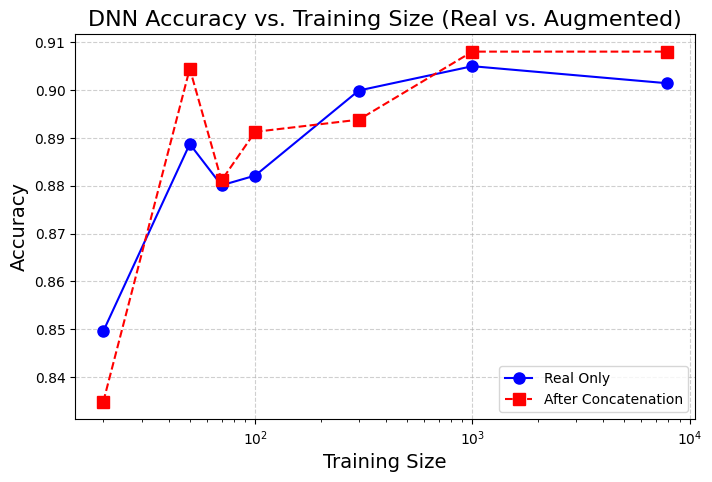

In [10]:
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_ds)]
dnn_accuracy_before = {}
dnn_accuracy_after = {}

for size in sample_sizes:
    print(f"\n[Real Data Only] Training size: {size}")
    train_subset = torch.utils.data.Subset(train_ds, range(size))
    train_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)

    input_dim = train_ds[0][0].shape[0]  
    hidden_dim = 128
    num_classes = len(np.unique(train_y_full)) if 'train_y_full' in globals() else 3
    dnn_model = DNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    dnn_model.to(device)
    
    print("Training DNN on real data...")
    acc_before, preds_before, labels_before = train_and_evaluate_dnn(dnn_model, train_loader, test_loader, num_epochs, learning_rate, device)
    print(f"DNN Test Accuracy (Real Data) for sample size {size}: {acc_before:.4f}")
    dnn_accuracy_before[size] = acc_before
    

    generator = Generator(
        latent_dim=latent_dim,
        condition_dim=condition_dim,
        num_classes=num_classes,
        start_dim=latent_dim * 2,
        n_layer=3,
        output_dim=input_dim  
    )
    discriminator = Discriminator(
        condition_dim=condition_dim,
        num_classes=num_classes,
        start_dim=256,
        n_layer=3,
        input_dim=input_dim
    )
    generator.to(device)
    discriminator.to(device)
    adversarial_loss = nn.BCELoss().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    gan_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    for epoch in range(gan_epochs):
        d_loss_epoch, g_loss_epoch = 0.0, 0.0
        for embeddings, labels in gan_loader:
            embeddings = embeddings.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            b_size = embeddings.size(0)
            valid = torch.ones(b_size, 1, device=device)
            fake = torch.zeros(b_size, 1, device=device)
            # -----------------
            # Train Generator
            # -----------------
            optimizer_G.zero_grad()
            z = torch.randn(b_size, latent_dim, device=device)
            gen_data = generator(z, labels)
            g_loss = adversarial_loss(discriminator(gen_data, labels), valid)
            g_loss.backward()
            optimizer_G.step()
            # -----------------
            # Train Discriminator
            # -----------------
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(embeddings, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_data.detach(), labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
        print(f"[GAN Epoch {epoch+1}/{gan_epochs}] D loss: {d_loss_epoch/len(gan_loader):.4f}, G loss: {g_loss_epoch/len(gan_loader):.4f}")
    

    synthetic_data_list = []
    synthetic_labels_list = []
    unique_labels = np.unique(train_y_full) if 'train_y_full' in globals() else [0,1,2]
    for lab in unique_labels:
        lab_tensor = torch.full((generation_size,), lab, dtype=torch.long, device=device)
        z = torch.randn(generation_size, latent_dim, device=device)
        synth = generator(z, lab_tensor).cpu().detach().numpy()
        synthetic_data_list.append(synth)
        synthetic_labels_list.append(np.full((generation_size,), lab))
    synthetic_x = np.concatenate(synthetic_data_list, axis=0)
    synthetic_y = np.concatenate(synthetic_labels_list, axis=0)
    
    # -------------------------------
    # Concatenate original training data with synthetic data
    # -------------------------------
    X_train = train_x_full[:size]
    y_train = train_y_full[:size]
    train_combined_x = np.concatenate([X_train, synthetic_x], axis=0)
    train_combined_y = np.concatenate([y_train, synthetic_y], axis=0)
    
    train_combined_dataset = TensorDataset(torch.tensor(train_combined_x, dtype=torch.float),
                                             torch.tensor(train_combined_y, dtype=torch.long))
    train_combined_loader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)

    dnn_model_aug = DNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    dnn_model_aug.to(device)
    
    print("Training DNN on real + synthetic (concatenated) data...")
    acc_after, preds_after, labels_after = train_and_evaluate_dnn(dnn_model_aug, train_combined_loader, test_loader, num_epochs, learning_rate, device)
    print(f"DNN Test Accuracy (After Concatenation) for sample size {size}: {acc_after:.4f}")
    dnn_accuracy_after[size] = acc_after

summary_df = pd.DataFrame(
    [[s, dnn_accuracy_before[s], dnn_accuracy_after[s]] for s in sample_sizes],
    columns=["Train Samples", "Real Only Accuracy", "After Concatenation Accuracy"]
)
print("Accuracy Summary:")
print(summary_df)
print(tabulate.tabulate(summary_df.values, headers=summary_df.columns, tablefmt="fancy_grid"))

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, list(dnn_accuracy_before.values()), marker='o', linestyle='-', color='b', markersize=8, label="Real Only")
plt.plot(sample_sizes, list(dnn_accuracy_after.values()), marker='s', linestyle='--', color='r', markersize=8, label="After Concatenation")
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("DNN Accuracy vs. Training Size (Real vs. Augmented)", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()
